# Анализ продуктовых метрик мобильного приложения
**Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:**
1. В первую очередь, его интересует показатель **retention**. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели **A/B тестирование** наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. **Предложите метрики** для оценки результатов последнего прошедшего тематического события в игре.

## Задание 1
**Retention** – один из самых важных показателей в компании. Ваша задача – **написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)**. Данные лежат в папке shared и имеют следующую структуру:

1. **reg_data.csv – данные о времени регистрации** https://disk.yandex.ru/d/IjdcpHnRLwbCsg
    * reg_ts - время регистрации пользователей
    * uid - id пользователя
2. **auth_data.csv – данные о времени захода пользователей в игру** https://disk.yandex.ru/d/mYP6j9czw2bCIw 
    * auth_ts - время захода пользователей в игру
    * uid - id пользователя

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

**Решение.** 

### Предварительный анализ данных.
План:
1. Импортируем данные.
2. Проверка типов данных. 
3. Расчет строк и столбцов в таблицах.
3. Расчет числа пропущенных значений.
4. Расчет числа повторяющихся строк.
5. Расчет числа уникальных значений для каждой колонки.
6. Расчет общего периода данных.

In [7]:
# Импортируем нужные библиотеки:
import pandas as pd
import numpy as np

import requests
from urllib.parse import urlencode
import json

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency, chi2 
from scipy import stats
import pingouin as pg

%matplotlib inline 
#хотим, чтобы наши графики сразу интерактивно рисовались в Jupiter Notebook

In [8]:
# Считаем файлы с Яндекс Диска:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

# Создадим функцию
def get_download_url(public_key):
    '''Загружает содержимое из файла на Яндекс Диске с использованием API.
       Принимает на вход: public_key - публичный ключ файла на Яндекс Диске
       Возвращает: ссылку для скачивания содержимого этого файла''' 
    # Получаем загрузочную ссылку:
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = json.loads(response.text)['href']  
    return download_url 

In [9]:
# Ссылки на файлы
public_key_reg_data ='https://disk.yandex.ru/d/IjdcpHnRLwbCsg'
public_key_auth_data = 'https://disk.yandex.ru/d/mYP6j9czw2bCIw'   

# Скачаем данные с использованием функции get_download_url
df_reg_data = pd.read_csv(get_download_url(public_key_reg_data), sep = ';')
df_auth_data = pd.read_csv(get_download_url(public_key_auth_data), sep = ';')

# Проверим датафреймы
print('df_reg_data.shape:', df_reg_data.shape)
print('df_auth_data.shape:', df_auth_data.shape)

df_reg_data.shape: (1000000, 2)
df_auth_data.shape: (9601013, 2)


In [10]:
# Посмотрим на типы данных:
print('Типы данных в таблице в таблице reg_data:\n{}\n'.format(df_reg_data.dtypes))
print('Типы данных в таблице в таблице auth_data:\n{}\n'.format(df_auth_data.dtypes))
# Все данные загрузились с типом int. Время в форате timestamp- это количество секунд, которые прошли с начала до 1970 года.

Типы данных в таблице в таблице reg_data:
reg_ts    int64
uid       int64
dtype: object

Типы данных в таблице в таблице auth_data:
auth_ts    int64
uid        int64
dtype: object



In [11]:
# Создадим колонку date_reg c датой регистрации в таблице df_reg_data в формате DateTime: 
df_reg_data['date_reg'] = pd.to_datetime(pd.to_datetime(df_reg_data.reg_ts, unit='s').dt.date)
                                         
# Создадим колонку date_auth c датой входа в приложение в таблице df_auth_data в формате DateTime: 
df_auth_data['date_auth'] = pd.to_datetime(pd.to_datetime(df_auth_data.auth_ts, unit='s').dt.date)

In [12]:
# Таблица с данными о времени регистрации:
df_reg_data
# В таблице 1000000 строк и 3 колонки

,reg_ts,uid,date_reg
0,911382223,1,1998-11-18
1,932683089,2,1999-07-22
2,947802447,3,2000-01-13
3,959523541,4,2000-05-28
4,969103313,5,2000-09-16
...,...,...,...
999995,1600874034,1110618,2020-09-23
999996,1600874086,1110619,2020-09-23
999997,1600874139,1110620,2020-09-23
999998,1600874191,1110621,2020-09-23


In [13]:
# Таблица с данными о времени захода пользователя в игру:
df_auth_data
# В таблице 9601013 строк и 3 колонки

,auth_ts,uid,date_auth
0,911382223,1,1998-11-18
1,932683089,2,1999-07-22
2,932921206,2,1999-07-25
3,933393015,2,1999-07-31
4,933875379,2,1999-08-05
...,...,...,...
9601008,1600874034,1110618,2020-09-23
9601009,1600874086,1110619,2020-09-23
9601010,1600874139,1110620,2020-09-23
9601011,1600874191,1110621,2020-09-23


In [14]:
# Посчитаем число пропущенных значений:
print('Пропущенных значений в таблице df_reg_data:\n{}\n'.format(df_reg_data.isna().sum()))
print('Пропущенных значений в таблице df_auth_data:\n{}'.format(df_auth_data.isna().sum()))

Пропущенных значений в таблице df_reg_data:
reg_ts      0
uid         0
date_reg    0
dtype: int64

Пропущенных значений в таблице df_auth_data:
auth_ts      0
uid          0
date_auth    0
dtype: int64


Пропущенных значений нет.

In [15]:
# Посчитаем число повторяющихся строк:
print('Повторяющихся строк в таблице df_reg_data: {}'.format(df_reg_data.duplicated().sum()))
print('Повторяющихся строк в таблице df_auth_data: {}'.format(df_auth_data.duplicated().sum()))

Повторяющихся строк в таблице df_reg_data: 0
Повторяющихся строк в таблице df_auth_data: 0


Повторяющихся строк нет ни в одной таблице.

In [16]:
# Посчитаем число уникальных значений для каждой колонки:
print('Число уникальных значений в таблице df_reg_data:\n{}\n'.format(df_reg_data.nunique()))
print('Число уникальных значений в таблице df_auth_data:\n{}\n'.format(df_auth_data.nunique()))

Число уникальных значений в таблице df_reg_data:
reg_ts      1000000
uid         1000000
date_reg       5110
dtype: int64

Число уникальных значений в таблице df_auth_data:
auth_ts      9180915
uid          1000000
date_auth       6169
dtype: int64



Видим, что число уникальных значений в колонке "*uid*" в таблицах **df_reg_data** и **df_auth_data** одно и то же, и равно 1000000, что говорит о том, что пользователей одинаковое число в этих таблицах. То есть общая колонка "*uid*" для этих двух таблиц содержит уникальные значения, и при соединении по ней любым из методов merge не будет происходить декартового произведения строк.  
В то же время в таблице **df_reg_data** число уникальных строк с временем регистрации пользователей совпадает с количеством уникальных пользователей, и равно 1000000, т.е. в таблице **df_reg_data** для каждого пользователя прописано свое уникальное время регистрации (скорее всего в данных ошибок нет, и они собраны верно).  
А вот в таблице **df_auth_data** всего строк 9601013. При этом уникальных пользователей 1000000, а число уникальных строк с временем захода пользователя в игру равно 9180915 (меньше общего числа строк, т.е. несколько пользователей заходили в игру в одно и то же время), и при этом один и тот же пользователь заходил в игру много раз.   

In [17]:
# Посчитаем минимальную и максимальную дату регистрации:
print('Минимальная дата регистрации: {}'.format(df_reg_data.date_reg.min()))
print('Максимальная дата регистрации: {}'.format(df_reg_data.date_reg.max()))

Минимальная дата регистрации: 1998-11-18 00:00:00
Максимальная дата регистрации: 2020-09-23 00:00:00


**То есть в нашей таблице данные за 2 года.** Поскольку нам требуется найти retention *по дням от даты регистрации*, мы не можем использовать все данные для визуализации и расчета retention. Поэтому начальная дата для расчета retention и конечная дата для расчета retention будет задаваться пользователем ПК. Также пользователь ПК сам в ручную будет задавать количество дней, за которое он хочет посчитать retention.

**Retention — это метрика, отвечающая на вопрос, сколько людей вернулись в день N после первого входа в продукт. Retention измеряется в процентах, то есть показывает долю вернувшихся людей от изначально пришедших.**

### Напишем план для расчета *retention*:
1. Объединить данные из двух датафреймов df_reg_data и df_auth_data.
2. Проверить, что пользователь ПК ввел правильные даты расчетного периода.
3. Отфильтровать данные внутри расчетного периода.
4. Собрать датафрейм с расчитанными когортами (датой регистрации) по дням пользования приложением. Посчитать число пользователей в каждой ячейке этой таблицы. 
5. Посчитать для каждой кагорты retention - долю вернувшихся пользователей на день N

In [18]:
def func_retention(df_reg_data, df_auth_data, start_date, end_date): 
    '''Принимает на вход: 
        1. reg_data - датафрейм с датой регистрации
        2. auth_data - датафрейм с датой входа в приложение
        3. start_date - дата регистрации, начиная с которой считаем retention (формат "YYYY-MM-DD")
        4. end_date - дата регистрации, до которой считаем retention (формат "YYYY-MM-DD")
       Строит: визуализацию heatmap
       Возвращает: таблицу Retention 
    '''
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    min_date = df_reg_data['date_reg'].min()   # минимальная дата в исходных данных
    max_date = df_reg_data['date_reg'].max()   # максимальная дата в исходных данных
    # Проверка входных данных:
    if start_date<min_date  or  start_date>max_date  or  end_date<min_date  or  end_date>max_date  or  start_date>end_date:
        mess_1 = "Исходные данные находится в диапазоне {min_date}  -  {max_date} \n"
        mess_2 = "Заданный расчетный период находится за пределами исходных данных, или start_date меньше end_date!"
        message = mess_1 + mess_2
        return (print(message.format(min_date = min_date, max_date = max_date)))
    else:
        # Соединим два датафрейма  df_auth_data  и  df_reg_data  по уникальной колонке uid, и оставим колонки с датой:
        df_all = df_auth_data.merge(df_reg_data, on ='uid', how = 'left')[['date_reg', 'date_auth', 'uid']]
        
        # Посчитаем количество дней между датой регистрации и датой захода в игру (дни пользования приложением)
        df_all['days'] = df_all.date_auth - df_all.date_reg
        df_all['days'] = df_all.days.dt.days
        
        # выделим требуемый период для кагорт:
        df_period = df_all.loc[(df_all.date_reg >= start_date) & (df_all.date_auth <= end_date)]
        
        # Соберем датафрейм с расчитанными когортами по дням. 
        # Для каждой даты регистрации и для каждого дня пользования приложением посчитаем число пользователей:
        cohort = df_period.groupby(['date_reg', 'days']).agg({'uid':'count'})

        # Преобразуем таблицу к виду: индексы - дата регистрации (кагорта пользователей), 
        # столбцы - дни пользования приложением, значения - число пользователей
        cohort = cohort.pivot_table(index='date_reg', columns='days', values='uid')

        # Делим количество уникальных клиентов в каждом периоде на общее количество клиентов в каждой кагорте.
        # Деление делаем по строкам. Затем умножаем на 100. 
        # Общее количество пользователей в каждой кагорте - это число пользователей в кагорте с номером 0.
        retention = cohort.divide(cohort[0], axis='index').mul(100).round(0)
        
        #построим heatmap для визуализации данных:
        plt.figure(figsize=(17,8))
        ax = sns.heatmap(retention, vmin=0, vmax=8, annot=True, fmt='.0f', cmap='RdPu')
        plt.xlabel('Days of using the app',size= 16)
        plt.ylabel('Cohorts', size= 16)
        plt.title('Retention rate %', size= 18)
        ax.set_yticklabels([t.get_text().split("T")[0] for t in ax.get_yticklabels()], rotation=0)
        plt.show()
        return retention

In [19]:
# Пользователь ПК задает расчетный период в формате "YYYY-MM-DD":
start_date = "2020-01-01"
end_date = "2020-01-15"

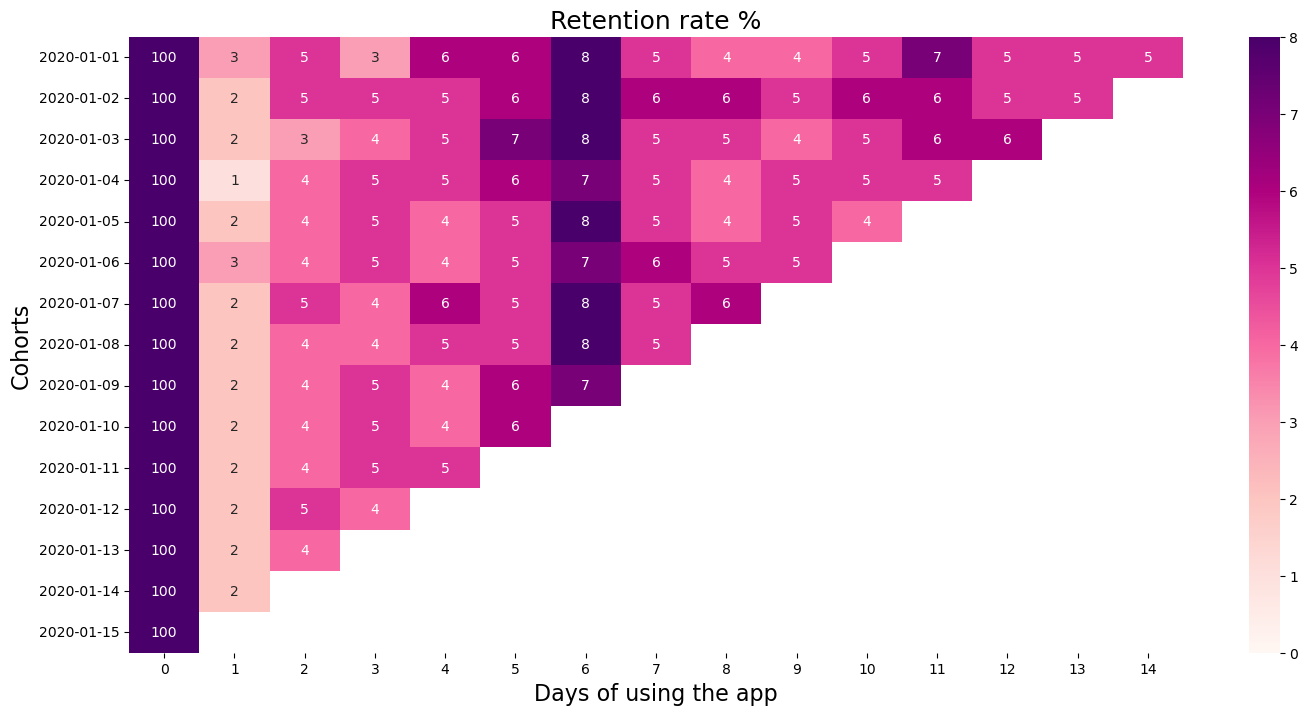

days,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
date_reg,,,,,,,,,,,,,,,
2020-01-01,100.0,3.0,5.0,3.0,6.0,6.0,8.0,5.0,4.0,4.0,5.0,7.0,5.0,5.0,5.0
2020-01-02,100.0,2.0,5.0,5.0,5.0,6.0,8.0,6.0,6.0,5.0,6.0,6.0,5.0,5.0,NaN
2020-01-03,100.0,2.0,3.0,4.0,5.0,7.0,8.0,5.0,5.0,4.0,5.0,6.0,6.0,NaN,NaN
2020-01-04,100.0,1.0,4.0,5.0,5.0,6.0,7.0,5.0,4.0,5.0,5.0,5.0,NaN,NaN,NaN
2020-01-05,100.0,2.0,4.0,5.0,4.0,5.0,8.0,5.0,4.0,5.0,4.0,NaN,NaN,NaN,NaN
2020-01-06,100.0,3.0,4.0,5.0,4.0,5.0,7.0,6.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN
2020-01-07,100.0,2.0,5.0,4.0,6.0,5.0,8.0,5.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,100.0,2.0,4.0,4.0,5.0,5.0,8.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,100.0,2.0,4.0,5.0,4.0,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
func_retention(df_reg_data, df_auth_data, start_date, end_date)

## Задание 2
Имеются **результаты A/B теста**, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что *ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.*   
**Вопрос:** *Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?*

**Описание данных:**
* user_id - идентификатор пользователя
* revenue - выручка на пользователя
* testgroup - группа пользователей:
    * а - контрольная (без изменений)
    * b- тестовая (с изменениями)

**Решение:**

In [21]:
# Ссылка на файл
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'

# Скачаем данные c яндекс диска с использованием функции get_download_url
df = pd.read_csv(get_download_url(public_key), sep = ';')

# Проверим датафрейм
print('df.shape:', df.shape)

df.shape: (404770, 3)


### Предварительный анализ данных.
План:
1. Импортируем данные.
2. Проверка типов данных. 
3. Расчет числа пропущенных значений.
4. Расчет числа повторяющихся строк.
5. Расчет числа строк и столбцов в таблице.
6. Расчет числа уникальных значений для каждой колонки.

In [22]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [23]:
# Посмотрим на типы данных:
df.dtypes

# Тип данных менять не нужно

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [24]:
# Посчитаем число пропущенных значений:
print('Пропущенных значений в таблице:\n{}\n'.format(df.isna().sum()))

# Посчитаем число повторяющихся строк:
print('Повтояряющихся строк в таблице: {}\n'.format(df.duplicated().sum()))

# Посчитаем общее количество строк и столбцов в таблице:
print('Общее количество строк и столбцов в таблице:\n{}\n'.format(df.shape))

# Посчитаем число уникальных значений для каждой колонки:
print('Число уникальных значений в таблице:\n{}\n'.format(df.nunique()))

# Пользователи поделены на уникальные группы
print('Пользователи поделены на уникальные группы:\n{}\n'.format(df.testgroup.unique()))

Пропущенных значений в таблице:
user_id      0
revenue      0
testgroup    0
dtype: int64

Повтояряющихся строк в таблице: 0

Общее количество строк и столбцов в таблице:
(404770, 3)

Число уникальных значений в таблице:
user_id      404770
revenue        1477
testgroup         2
dtype: int64

Пользователи поделены на уникальные группы:
['b' 'a']



*Следовательно, пропущенных значений нет, повторяющихся строк нет. А общее число строк в таблице равно 404770, и оно совпадает с числом уникальных user_id, т.е. у нас дана таблица в которой для каждого уникального пользователя указан параметр revenue, т.е. выручка, и указан номер группы а (контрольная) или b (тестовая).* 

In [25]:
# Посмотрим, сколько уникальных пользователей в каждой из групп:
df.groupby('testgroup', as_index = False)[['user_id']].nunique()

,testgroup,user_id
0,a,202103
1,b,202667


* **В группе а (контрольной) всего 202103 пользователей**
* **В группе b (тестовой) всего 202667 пользователей**  
*Т.е. в двух группах пользователей примерно одинаковое число.* 

In [26]:
# Посчитаем число платящих пользователей в двух группах:
df.query("revenue > 0").groupby('testgroup', as_index = False)[['user_id']].nunique()

,testgroup,user_id
0,a,1928
1,b,1805


* **В группе а (контрольной) 1928 платящих пользователей**
* **В группе b (тестовой) 1805 платящих пользователей**  
*Т.е. в двух группах примерно одинаковое число платящих пользователей, но платящих пользователей значительно меньше, чем неплатящих.* 

## Выведем описательные статистики каждой группы пользователей, и построим распределение выручки.

In [27]:
# разделяем всех пользователей на a и b
groub_all_a = df.query('testgroup == "a" ')
groub_all_b = df.query('testgroup == "b" ')

In [28]:
# разделяем клиентов (платящих пользователей) на группы a и b:
groub_pay_a = df.query('testgroup == "a" & revenue > 0')
groub_pay_b = df.query('testgroup == "b" & revenue > 0')

Сравним пользователей двух групп:

In [29]:
# выведем описательные статистики всех пользователей группы "a":
groub_all_a.describe()

,user_id,revenue
count,202103.000000,202103.000000
mean,202555.909843,25.413720
std,116802.329266,920.768137
min,2.000000,0.000000
25%,101502.500000,0.000000
50%,202988.000000,0.000000
75%,303559.000000,0.000000
max,404769.000000,37433.000000


In [30]:
# выведем описательные статистики всех пользователей группы "b":
groub_all_b.describe()

,user_id,revenue
count,202667.000000,202667.000000
mean,202215.564389,26.751287
std,116891.926690,287.324162
min,1.000000,0.000000
25%,100855.500000,0.000000
50%,201821.000000,0.000000
75%,303602.500000,0.000000
max,404770.000000,4000.000000


Сравнивая описательные статистики всех пользователей разных групп a и b, можно заметить, что в группах а и b средние значения выручки похожи, а вот стандартное отклонение и максимальное значение выручки сильно различаются.

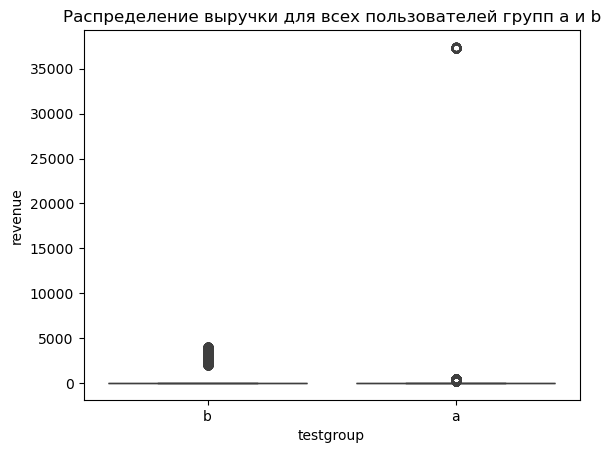

In [31]:
# График boxplot позволяет нарисовать сравнение распределения двух групп.
plt.title('Распределение выручки для всех пользователей групп a и b')
ax = sns.boxplot(data = df, x = 'testgroup', y = 'revenue')

# в самом ящике лежит примерно 50% всех наблюдений
# усы показывают крайние точки распределения
# отдельно стоящие точки - выбросы в данных

<AxesSubplot:title={'center':'Распределение выручки для платящих пользователей двух групп'}, xlabel='revenue', ylabel='Count'>

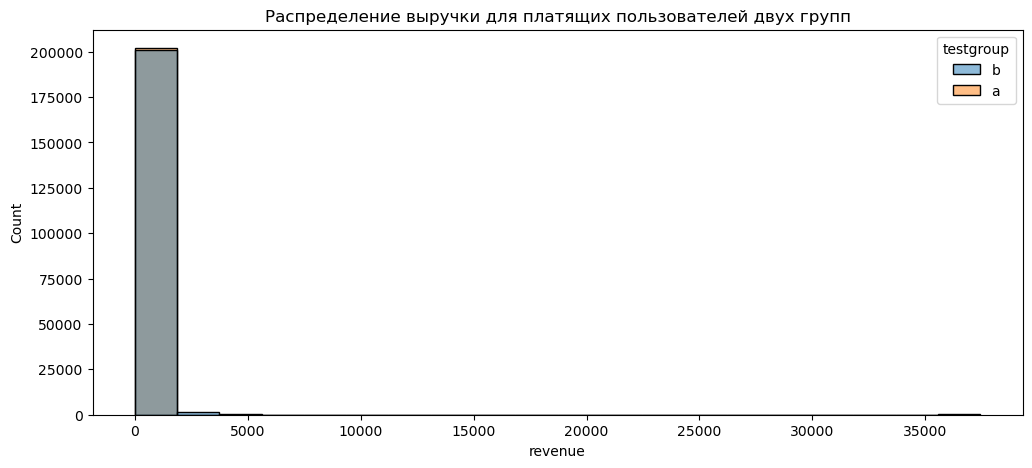

In [32]:
# Построим распределение выручки пользователей для двух групп:
plt.figure(figsize=(12, 5))
plt.title('Распределение выручки для платящих пользователей двух групп')
sns.histplot(data = df, x='revenue', hue='testgroup')

Сравнивая распределение выручки всех пользователей для двух групп на графике boxplot и на гистограмме, видно, что в группе а (контрольной) имеются большие выбросы.

**Сравним клиентов (платящих пользователей) двух групп:**

In [33]:
# выведем описательные статистики клиентов (платящих пользователей) группы "a":
groub_pay_a.describe()

,user_id,revenue
count,1928.000000,1928.000000
mean,200152.677905,2663.998444
std,116596.504905,9049.039763
min,73.000000,200.000000
25%,99323.000000,257.000000
50%,199854.500000,311.000000
75%,299664.250000,361.000000
max,404768.000000,37433.000000


In [34]:
# выведем описательные статистики клиентов (платящих пользователей) группы "b":
groub_pay_b.describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


* Средний доход на платящего пользователя в контрольной группе a немного меньше, чем в тестовой группе b
* Минимальное и максимальное значения выручки для платящих пользователей в двух группах сильно различаются.
* Стандартное отклонение выручки для платящих пользователей в двух группах сильно различаются.  
*Разберемся с этим более подробно, и посмотрим на форму распределения выручки для этих групп пользователей.*

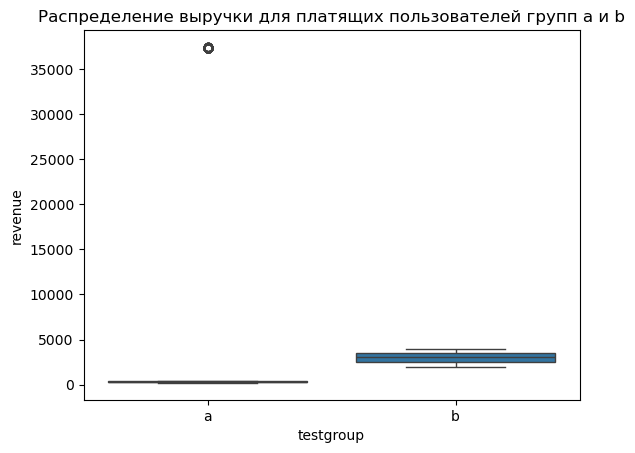

In [35]:
# График boxplot позволяет нарисовать сравнение распределения двух переменных
plt.title('Распределение выручки для платящих пользователей групп a и b')
ax = sns.boxplot(data = df.query("revenue > 0"), x = 'testgroup', y = 'revenue')

<AxesSubplot:title={'center':'Распределение выручки для платящих пользователей двух групп'}, xlabel='revenue', ylabel='Count'>

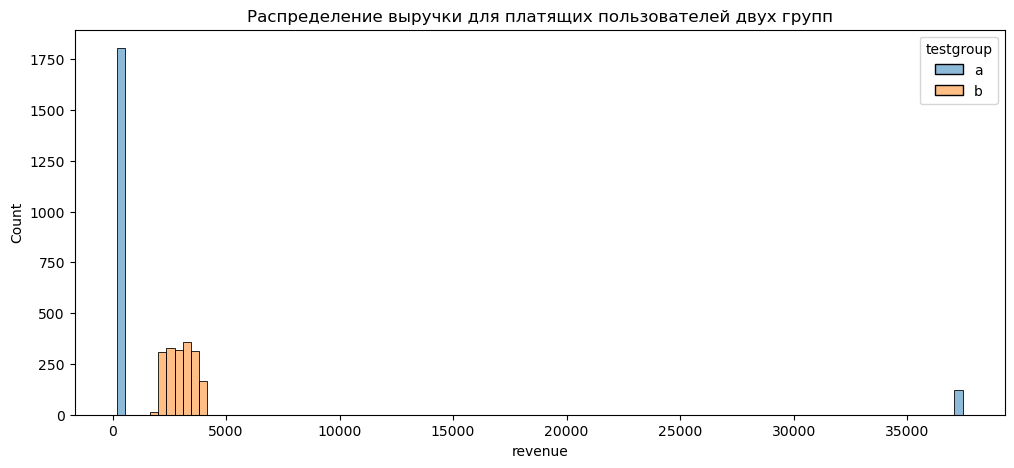

In [36]:
# Построим распределение выручки клиентов (платящих пользователей) для двух групп:
plt.figure(figsize=(12, 5))
plt.title('Распределение выручки для платящих пользователей двух групп')
sns.histplot(data = df.query("revenue > 0"), x='revenue', hue='testgroup')

Сравнивая распределение выручки платящих пользователей для двух групп на графике boxplot и на гистограмме, видно, что распределения выручки для двух групп кардинально различаются между собой (как по форме, так и по значениям). В группе а (контрольной) имеются большие выбросы.

<AxesSubplot:title={'center':'Распределение выручки для платящих пользователей тестовой группы b'}, xlabel='revenue', ylabel='Count'>

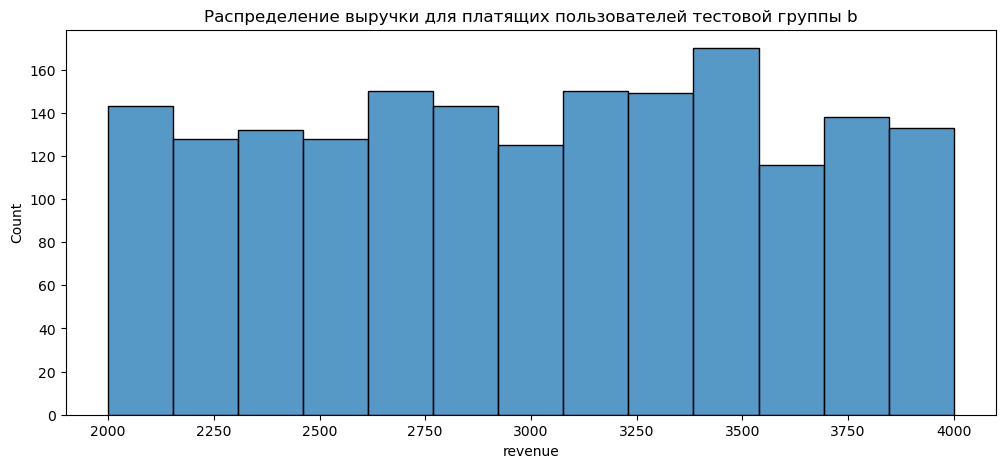

In [37]:
# Построим распределение выручки клиентов (платящих пользователей) для группы b:
plt.figure(figsize=(12, 5))
plt.title('Распределение выручки для платящих пользователей тестовой группы b')
sns.histplot(groub_pay_b.revenue)

<AxesSubplot:title={'center':'Распределение выручки для платящих пользователей контрольной группы a'}, xlabel='revenue', ylabel='Count'>

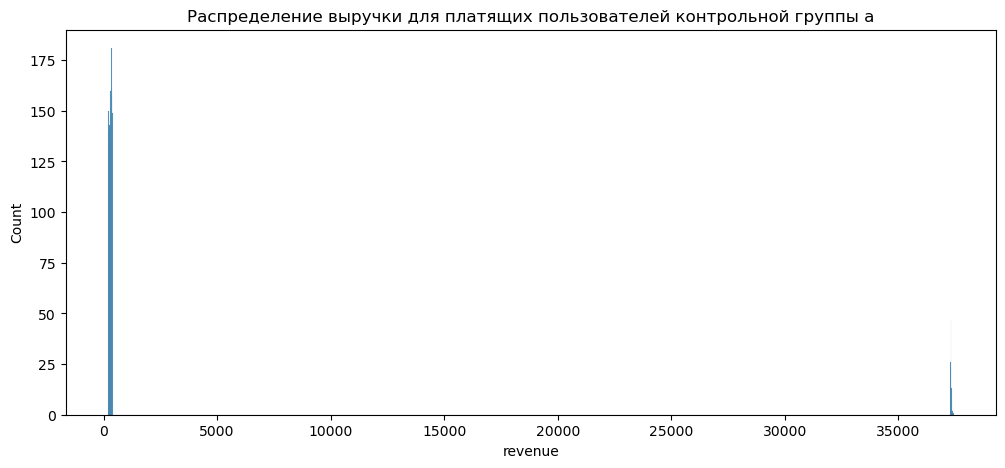

In [38]:
# Построим распределение выручки клиентов (платящих пользователей) для группы a:
plt.figure(figsize=(12, 5))
plt.title('Распределение выручки для платящих пользователей контрольной группы a')
sns.histplot(groub_pay_a.revenue)

Форма распределения выручки для платящих пользователей групп а и b очень сильно различается.  
* В тестовой группе b распределение по форме похоже на равномерное.
* В контрольной группе a распределение с двумя модами, оно несимметричное, не является нормальным, не является симметричным. Выбросы в данных визуально ограничены числом 3500.

**Рассмотрим более подробно выбросы платящих пользователей группы а:**

<AxesSubplot:title={'center':'Распределение выручки (revenue < 3500) для платящих пользователей контрольной группы a'}, xlabel='revenue', ylabel='Count'>

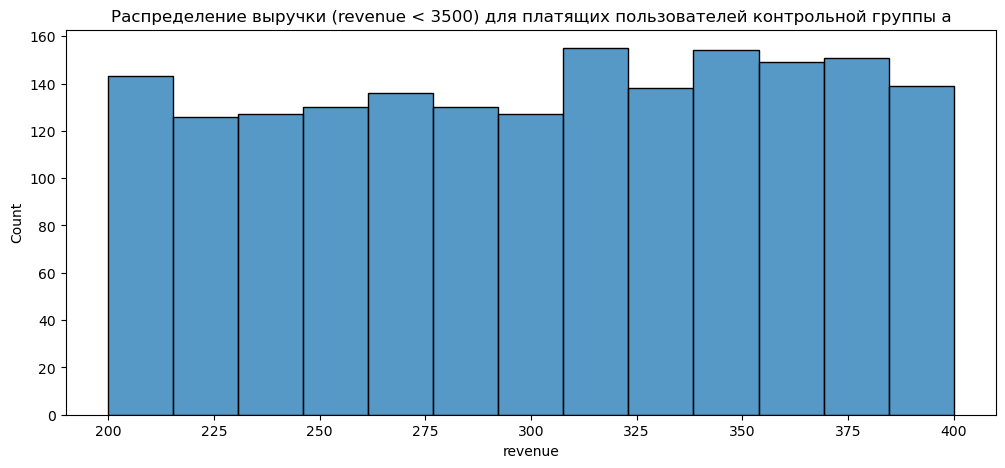

In [39]:
# Построим распределение выручки клиентов (платящих пользователей) для группы a (выручка < 3500):
plt.figure(figsize=(12, 5))
plt.title('Распределение выручки (revenue < 3500) для платящих пользователей контрольной группы a')
sns.histplot(groub_pay_a.query("revenue < 3500").revenue)

<AxesSubplot:title={'center':'Распределение выручки (revenue > 3500) для платящих пользователей контрольной группы a'}, xlabel='revenue', ylabel='Count'>

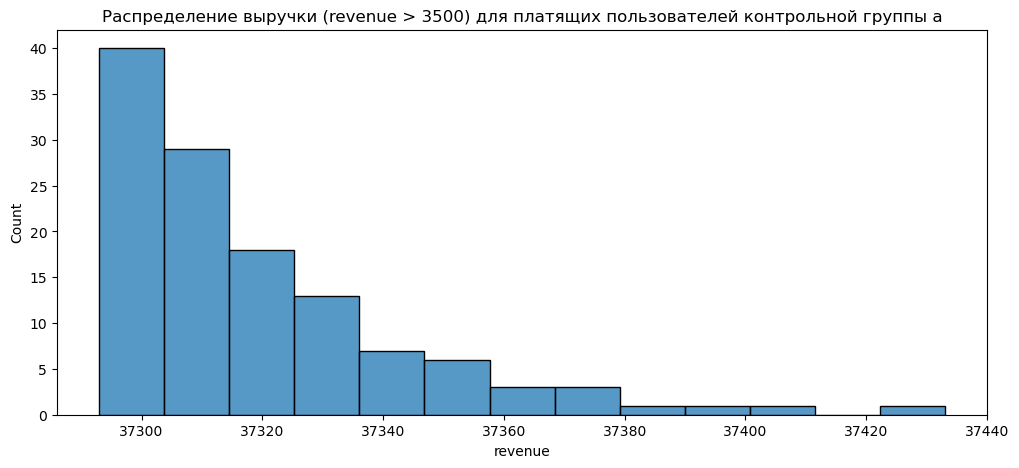

In [40]:
# Построим распределение выручки клиентов (платящих пользователей) для группы a (выручка > 3500):
plt.figure(figsize=(12, 5))
plt.title('Распределение выручки (revenue > 3500) для платящих пользователей контрольной группы a')
sns.histplot(groub_pay_a.query("revenue > 3500").revenue)

**По графиками для платящих пользователей можно заметить:**
* В **тестовой группе b** выбросов нет, пользователи этой группы приносят прибыли от 2000 у.е. до 4000 у.е. Форма распределения похожа на равномерное.
* В **контрольной группе а** для разных пользователей очень большой разброс по выручке:
    * Основная часть пользователей приносят прибыли от 200 у.е. до 400 у.е. Форма распределения выручки для них похожа на равномерное.
    * В контрольной группе а есть особенные пользователи ("выбросы") у которых сумма чека составляет более 35000 условных единиц. Распределение этих пользователей по форме похоже на экспоненциальное.   

Таким образом, если сравнивать два распределения контрольной группы а (большая часть пользователей и "выбросы"), то они имеют разную форму. Выбросы довольно значительно меняют общую картину распределения группы а.
Ниже посчитаем, какой процент пользователей группы а составляют выбросы, и какой процент дохода они приносят компании, и оценим, насколько сильно их наличие влияет на наши данные. 

In [41]:
# Посчитаем число выбросов для платящих пользователей группы а:
outliers = groub_pay_a.query("revenue > 3500").revenue.count()
print('Число выбросов для платящих пользователей группы а: {}\n'.format(outliers))

# Посчитаем общее число строк в таблице платящих пользователей группы а:
all_values = groub_pay_a.revenue.count()
print('Число строк в таблице платящих пользователей группы а: {}\n'.format(all_values))

# Посчитаем, какую долю от всех платящих пользователей занимают выбросы:
outliers_ratio = outliers/all_values * 100
print('Выбросы составляют {} % от всех платящих пользователей группы а.'.format(outliers_ratio.round(0)))

Число выбросов для платящих пользователей группы а: 123

Число строк в таблице платящих пользователей группы а: 1928

Выбросы составляют 6.0 % от всех платящих пользователей группы а.


In [42]:
# Посчитаем доход от выбросов для платящих пользователей группы а:
outliers_rev = groub_pay_a.query("revenue > 3500").revenue.sum()
print('Доход от выбросов для платящих пользователей группы а: {}\n'.format(outliers_rev))

# Посчитаем общий доход от всех платящих пользователей группы а:
all_values_rev = groub_pay_a.revenue.sum()
print('Общий доход от всех платящих пользователей группы а: {}\n'.format(all_values_rev))

# Посчитаем, какой процент дохода от платящих пользователй занимают выбросы:
outliers_ratio_rev = outliers_rev/all_values_rev * 100
print('Доход от выбросов составляет {} % от дохода всех платящих пользователей группы а.'.format(outliers_ratio_rev.round(0)))

Доход от выбросов для платящих пользователей группы а: 4590252

Общий доход от всех платящих пользователей группы а: 5136189

Доход от выбросов составляет 89.0 % от дохода всех платящих пользователей группы а.


**Таким образом, несмотря на то, что выбросы составляют только 6% от всех клиентов группы а, они приносят около 89% от общего дохода группы а, считать их случайными неверно.**

* ***Такое большое отличие в форме распределения выручки групп а и b ставит под сомнение корректность проведенного эксперимента и правильность работы системы сплитования, поскольку сегменты пользователй в группе a и группе b значительно отличаются друг от друга. Рекомендуется проверить систему сплитования на адекватность с помощью А/А-тестирования.***

* Однако, поскольку форма распределения выручки основной части пользователей группы а (равномерное) похожа на форму распределения группы b (тоже равномерное), то можно предположить, что разный характер распределения выручки групп а и b связан с акционным предложением, и, возможно, не было ошибок в работе системы сплитования, и она правильно разделила пользователей на сегменты. 

## Выбор метрики.

*Команда приложения разработала наборы акционных предложений. 
Нам предоставлены для разных пользователей данные о платежах, количестве платящих и неплатящих пользователей. 
Поэтому мы можем исследовать следующие метрики:*   
1. ***ARPU*** - средний доход с привлеченного пользователя. ARPU = Доход/Число_пользователей (это целевая метрика - показатель доходов).   
**По сути ARPU - это средняя выручка на привлеченного пользователя.** 
2. ***ARPPU*** - средний доход с привлеченного клиента, т.е. платящего пользователя. ARPPU = Доход/Число_клиентов (это целевая метрика - показатель доходов). **По сути ARPPU - это средняя выручка на клиента.** 
3. ***Конверсия в покупку*** - число пользователей, которые сделали покупку к общему числу пользователей (целевая метрика, тоже напрямую влияет на доходы в компании).

*Мы заинтересованы в том, чтобы для некоторой группы средняя выручка была больше, ARPU был больше, ARPPU тоже был выше, конверсия в покупку была больше, причем чтобы это увеличение было статистически значимо.* 

## Расчет выбранных метрик.

In [43]:
# ARPU:
all_users = df.groupby('testgroup', as_index=False)\
    .agg({'revenue': 'sum', 'user_id': 'count'})\
    .rename(columns = {"revenue": "all_revenue", "user_id": 'numb_users'}) 
all_users["ARPU"] =  all_users.all_revenue / all_users.numb_users
all_users

,testgroup,all_revenue,numb_users,ARPU
0,a,5136189,202103,25.413720
1,b,5421603,202667,26.751287


In [44]:
# Посчитаем, на сколько процентов ARPU в тестовой группе больше, чем в контрольной:
percent = round(all_users.query('testgroup == "b"').ARPU[1] * 100 /  all_users.query('testgroup == "a"').ARPU[0]) - 100
print('ARPU в тестовой группе на {}% выше, чем ARPU в контрольной группе a.'.format(percent))

ARPU в тестовой группе на 5% выше, чем ARPU в контрольной группе a.


In [45]:
# ARPPU:
pay_users = df.query("revenue > 0").groupby('testgroup', as_index = False)\
    .agg({'revenue': 'sum', 'user_id': 'count'})\
    .rename(columns = {"revenue": "all_revenue", "user_id": 'numb_clients'}) 
pay_users["ARPPU"] =  pay_users.all_revenue / pay_users.numb_clients
pay_users

,testgroup,all_revenue,numb_clients,ARPPU
0,a,5136189,1928,2663.998444
1,b,5421603,1805,3003.658172


In [46]:
# Конверсия в покупку (CR - convension rate).
# Объединим 2 таблицы, и посчитаем конверсию в покупку:
pay_users = pay_users[['testgroup', 'numb_clients', 'ARPPU']]
df_metrics = all_users.merge(pay_users, on = "testgroup", how = "inner")
df_metrics['CR_percent'] = df_metrics.numb_clients / df_metrics.numb_users * 100
df_metrics

,testgroup,all_revenue,numb_users,ARPU,numb_clients,ARPPU,CR_percent
0,a,5136189,202103,25.413720,1928,2663.998444,0.953969
1,b,5421603,202667,26.751287,1805,3003.658172,0.890624


**Выводы из этой таблицы:**
* **ARPU** пользователей группы **b выше**, чем **ARPU** пользователей группы **a**.
* **ARPPU** пользователей группы **b выше**, чем **ARPPU** пользователей группы **a**. 
* **CR** пользователей группы **a выше**, чем **CR** пользователей группы **b**.

Проверим, являются ли эти различия статистически значимы, или нет.

## Выбор теста для каждой метрики, проведение теста и выводы. 

### Выбор теста для метрики CR, проведение теста и выводы.

* При расчете метрики CR работаем с категориальными данными (разбиваем пользователей на категорию "клиент" и "пользователь"), собираем общую таблицу. 
* Клиент - платящий пользователь, Пользователь - это любой привлеченный пользователь.   
* CR в покупку = (Число_платящих_пользователей / Число_всех_пользователей)*100%

In [47]:
# Соберем таблицу для работы с метрикой CR:
df_metrics = df_metrics.set_index('testgroup')
df_CR = df_metrics[['numb_users', 'numb_clients']].rename(columns = {'numb_users': 'users', "numb_clients": 'clients'})
df_CR

,users,clients
testgroup,,
a,202103,1928
b,202667,1805


Поскольку у нас есть две категориальные переменные group (принимает значение a или b) и тип пользователей (users - привлеченные пользователи и clients - клиенты) → нужен **критерий хи-квадрат**. Критерий хи-квадрат можно использовать для проверки того, равны ли у двух категориальных величин распределения.

Гипотеза $H_0$: взаимосвязи между переменными (между типом пользователя и типом группы) нет  
Гипотеза $H_1$: взаимосвязь есть

In [48]:
# В метод хи-квадрат положим табличку выше.
stat, p, dof, expected = chi2_contingency(df_CR)

In [49]:
stat, p
# Получили значение статистики хи-квадрат и р-значение. Видно, что р-значение маленькое.

(4.294148751290091, 0.03824373651044168)

Интерпретируем результат:

In [50]:
# Сравним значение расчитанного р-значения с критическим значением:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


Таким образом, нужно отклонить гипотезу $H_0$ о том, что взаимосвязи между типом группы и типом пользователя нет. То есть эта взаимосвязь есть, и пользователи разных групп: а (контрольная группа) и b (тестовая группа) имеют разное число клиентов и привлеченных пользователей, причем это различие статистически значимо. 
Выше, мы считали: 
1. CR группы a = 0.95
2. CR группы b = 0.89

Следовательно, в CR группе a больше чем CR в группе b, причем это различие статистически значимо. Однако средняя выручка на пользователя (ARPU) и средняя выручка на клиента (ARPPU) в группе b оказалась выше, чем в группе a. Поэтому, прежде чем делать окончательный вывод о выборе акционного предложения, нужно проверить, является ли различие в этих метриках APRU и ARPPU статистически значимым, или нет.

### Выбор теста для метрики ARPU, проведение теста и выводы.

ARPU - средняя выручка на одного пользователя

In [51]:
# Соберем для всех привлеченных пользователей в таблицу с номером группы и выручкой:
df_ARPU = df[['testgroup', 'revenue']]
df_ARPU.head()

,testgroup,revenue
0,b,0
1,a,0
2,a,0
3,b,0
4,b,0


Поскольку у нас есть количественная переменная (revenue) и категориальная переменная (testgroup) → нужен **t-тест**. t-тест можно использовать для проверки того, что средние значения двух выборок относятся к одной и той же генеральной совокупности.

Гипотеза $H_0$: различий между средними значениями (ARPU - средняя выручка на пользователя) группы a и группы b нет, т.е. наши выборки относятся к одной и той же ГС   
Гипотеза $H_1$: различие между средними значениями (ARPU - средняя выручка на пользователя) двух выборок групп a и b статистически значимо.

***Но перед тем, как использовать t-тест, нужно проверить что его можно применить.***

***Условия применимости t-теста:***
* Дисперсии внутри наших групп должны быть примерно одинаковы (требование гомогенности дисперсий)
* Выборки большого объема и нет выбросов, или сравниваемые выборки должны происходить из *нормально распределенных совокупностей*. 
* Сравниваемые выборки должны быть независимы (этим занимается система сплитования, и это проверяется на этапе А/А-тестирования).

In [52]:
# Чтобы убедиться в гомогенности дисперсии, можно применить специальный тест Левина.

# Нулевая гипотеза  H0: «Дисперсия среди групп одинакова».
# Альтернативная гипотеза H1: «Дисперсия среди групп не одинакова».

stats.levene(df_ARPU.query('testgroup == "a"').revenue, df_ARPU.query('testgroup == "b"').revenue)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

Получили, что p-значение > 0.05, следовательно мы не можем отклонить нулевую гипотезу о равенстве дисперсий. Т.е. мы можем считать, что дисперсии однородны. 

In [53]:
# Чтобы убедиться в нормальности распределения, можно применить специальный тест Агостино-Пирсона.  

# Нулевая гипотеза H0: Выборка изъята из генеральной совокупности, где распределение признака соответствует нормальному
# Нулевая гипотеза H1: Выборка изъята из генеральной совокупности, где распределение признака НЕ соответствует нормальному

pg.normality(data=df_ARPU, dv="revenue", 
                   group="testgroup", method="normaltest")

,W,pval,normal
testgroup,,,
b,326622.395409,0.0,False
a,585152.731273,0.0,False


Этот тест показал, что наши данные не являются нормальными.

Наши выборки большого объема, но в выборке группы "a" **есть выбросы!**. А t-тест при наличии выбросов может давать некорректные результаты.

Поскольку наши данные не удовлетворяют условиям применения t-критерия, то можно применить критерий **U- критерий Манна-Уитни**. Он не требует предположений о распределении данных, достаточно устойчив к выбросам, и может быть использован для любого типа данных (кроме различного направления асимметрии в данных).  
Однако, его интерпретация достаточно сложная. Нулевая гипотеза U-теста Манна-Уитни заключается в том, что выборки обеих групп были взяты из одной и той же генеральной совокупности. Таким образом, если нулевая гипотеза верна, это означает, что нет никакой разницы в средних рангах между двумя группами, потому что обе группы имеют одинаковые шансы иметь низкие и высокие ранги. Но это не имеет отношения к интересующей нас метрике ARPU.    
**Поскольку наших данных не очень много, целесообразнее всего использовать метод bootstrap, который работает на любых данных и имеет понятную интерпретацию, хотя и трудозатратен (в нашей задаче это не очень критично).**

Для метода bootstrap:  
Гипотеза $H_0$: различий между средними значениями выручки (ARPU) двух выборок групп a и b нет.  
Гипотеза $H_1$: различие между средними значениями выручки (ARPU) двух выборок групп a и b статистически значимо.

In [54]:
# bootstrap.
# В каждой нашей симуляции записываем разницу между средней выручкой (ARPU) в контрольной и в тестовой группах. 
# И потом можем построить доверительный интервал для разницы между ARPU, которую мы бы получали при многократном повторении эксперимента

control_df = df[df.testgroup == 'a'] # создадим датафрейм с данными только по контрольной группе
exp_df = df[df.testgroup == 'b']     # создадим датафрейм с данными только по тестовой группе
ARPU_diff = []                       # создадим список, куда будем записывать разницу между ARPU

for i in range(10000):    # делаем эксперимент 10000 раз
    sample_data_control = control_df.sample(frac=1, replace=True)   # извлекаем из контрольных данных выборку i
    sample_ARPU_control = sample_data_control.revenue.mean()        # посчитаем ARPU для этой выборки i
    
    sample_data_exp = exp_df.sample(frac=1, replace=True)           # извлекаем тестовых данных выборку j
    sample_ARPU_exp = sample_data_exp.revenue.mean()                # посчитаем ARPU для этой выборки j
    
    sample_ARPU_diff = sample_ARPU_control - sample_ARPU_exp     # посчитаем разницу между ARPU двух выборок
    ARPU_diff.append(sample_ARPU_diff)

In [55]:
# Посчитаем 95%-ный доверительный интервал для разницы между ARPU:
quan_0975 = pd.Series(ARPU_diff).quantile(0.975).round()
quan_0025 = pd.Series(ARPU_diff).quantile(0.025).round()
print("Доверительный интервал для разницы между ARPU в двух группах равен: [{}; {}]".format(quan_0025, quan_0975))

Доверительный интервал для разницы между ARPU в двух группах равен: [-6.0; 3.0]


Доверительный интервал для разницы между ARPU двух групп обеспечивает диапазон значений, который с 95%-ной вероятностью содержит истинную разницу между ARPU генеральной совокупности.  
Т.е. с вероятностью 95% различия между ARPU в нашем эксперименте находится в диапазоне [-6, 3]. Поскольку этот интервал содержит значение «0», это означает, что, возможно, нет никакой разницы в ARPU для двух групп. Другими словами, мы не можем с 95% уверенностью сказать, что существует разница в ARPU для двух групп, и не можем отклонить нулевую гипотезу о равенстве APRU для двух групп. Т.е. ARPU не изменилось статистически значимо.

### Выбор теста для метрики ARPPU, проведение теста и выводы.

ARPPU - средняя выручка на одного клиента (платящего пользователя)

In [56]:
# Соберем всех клиентов (платящих пользователей) в таблицу с номером группы и выручкой:
df_ARPPU = df.query('revenue > 0')[['testgroup', 'revenue']]
df_ARPPU.head()

,testgroup,revenue
72,a,351
160,b,3797
341,a,290
377,b,3768
385,a,250


Поскольку у нас есть количественная переменная (revenue) и категориальная переменная (testgroup) → нужен **t-тест**. t-тест можно использовать для проверки того, что средние значения двух выборок относятся к одной и той же генеральной совокупности.

Гипотеза $H_0$: различий между средними значениями (ARPPU - средняя выручка на клиента) группы a и группы b нет, т.е. наши выборки относятся к одной и той же ГС   
Гипотеза $H_1$: различие между средними значениями (ARPPU - средняя выручка на клиента) двух выборок групп a и b статистически значимо.

***Но перед тем, как использовать t-тест, нужно проверить что его можно применить.***

***Условия применимости t-теста:***
* Дисперсии внутри наших групп должны быть примерно одинаковы (требование гомогенности дисперсий)
* Выборки большого объема и нет выбросов, или сравниваемые выборки должны происходить из *нормально распределенных совокупностей*. 
* Сравниваемые выборки должны быть независимы (этим занимается система сплитования, и это проверяется на этапе А/А-тестирования).

In [57]:
# Чтобы убедиться в гомогенности дисперсии, можно применить специальный тест Левина.

# Нулевая гипотеза  H0: «Дисперсия среди групп одинакова».
# Альтернативная гипотеза H1: «Дисперсия среди групп не одинакова».

stats.levene(df_ARPPU.query('testgroup == "a"').revenue, df_ARPPU.query('testgroup == "b"').revenue)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

Получили, что p-значение < 0.05, следовательно мы можем отклонить нулевую гипотезу о равенстве дисперсий, т.е. дисперсии в наших выборках различны. 

In [58]:
# Чтобы убедиться в нормальности распределения, можно применить специальный тест Агостино-Пирсона.  

# Нулевая гипотеза H0: Выборка изъята из генеральной совокупности, где распределение признака соответствует нормальному
# Нулевая гипотеза H1: Выборка изъята из генеральной совокупности, где распределение признака НЕ соответствует нормальному

pg.normality(data=df_ARPPU, dv="revenue", 
                   group="testgroup", method="normaltest")

,W,pval,normal
testgroup,,,
a,1394.945784,1.234161e-303,False
b,1068.860008,7.943249e-233,False


Этот тест показал, что наши данные не являются нормальными.

Наши выборки большого объема, но в выборке группы "a" **есть выбросы!**. А t-тест при наличии выбросов может давать некорректные результаты.

Поскольку наши данные не удовлетворяют условиям применения t-критерия, то можно применить критерий **U- критерий Манна-Уитни**. Он не требует предположений о распределении данных, достаточно устойчив к выбросам, и может быть использован для любого типа данных (кроме различного направления асимметрии в данных).  
Однако, его интерпретация достаточно сложная. Нулевая гипотеза U-теста Манна-Уитни заключается в том, что выборки обеих групп были взяты из одной и той же генеральной совокупности. Таким образом, если нулевая гипотеза верна, это означает, что нет никакой разницы в средних рангах между двумя группами, потому что обе группы имеют одинаковые шансы иметь низкие и высокие ранги. Но это не имеет отношения к интересующей нас метрике ARPU.    
**Поскольку наших данных не очень много, целесообразнее всего использовать метод bootstrap, который работает на любых данных и имеет понятную интерпретацию, хотя и трудозатратен (в нашей задаче это не очень критично).**

**Для метода bootstrap:**  
Гипотеза $H_0$: различий между средними значениями (ARPPU - средняя выручка на клиента) двух выборок групп a и b нет.  
Гипотеза $H_1$: различие между средними значениями (ARPPU - средняя выручка на клиента) двух выборок групп a и b статистически значимо.

In [59]:
# bootstrap.
# В каждой нашей симуляции записываем разницу между средней выручкой на клиента (ARPPU) в контрольной и в тестовой группах. 
# И потом можем построить доверительный интервал для разницы между ARPPU, которую мы бы получали при многократном повторении эксперимента

control_df =  df[(df.revenue > 0) & (df.testgroup == 'a')] # создадим датафрейм с данными только по контрольной группе
exp_df =  df[(df.revenue > 0) & (df.testgroup == 'b')]     # создадим датафрейм с данными только по тестовой группе
ARPPU_diff = []                                            # создадим список, куда будем записывать разницу между ARPPU

for i in range(10000):    # делаем эксперимент 10000 раз
    sample_data_control = control_df.sample(frac=1, replace=True)    # извлекаем из контрольных данных выборку i
    sample_ARPPU_control = sample_data_control.revenue.mean()        # посчитаем ARPPU для этой выборки i
    
    sample_data_exp = exp_df.sample(frac=1, replace=True)            # извлекаем тестовых данных выборку j
    sample_ARPPU_exp = sample_data_exp.revenue.mean()                # посчитаем ARPPU для этой выборки j
    
    sample_ARPPU_diff = sample_ARPPU_control - sample_ARPPU_exp      # посчитаем разницу между ARPU двух выборок
    ARPPU_diff.append(sample_ARPPU_diff)

In [60]:
# Посчитаем 95%-ный доверительный интервал для разницы между ARPPU:
quan_0975 = pd.Series(ARPPU_diff).quantile(0.975).round()
quan_0025 = pd.Series(ARPPU_diff).quantile(0.025).round()
print("Доверительный интервал для разницы между ARPPU в двух группах равен: [{}; {}]".format(quan_0025, quan_0975))

Доверительный интервал для разницы между ARPPU в двух группах равен: [-735.0; 66.0]


Доверительный интервал для разницы между ARPPU двух групп обеспечивает диапазон значений, который с 95%-ной вероятностью содержит истинную разницу между ARPPU генеральной совокупности.  
Т.е. с вероятностью 95% различия между ARPPU в нашем эксперименте находится в диапазоне [-733, 66]. Поскольку этот интервал содержит значение «0», это означает, что, возможно, нет никакой разницы в ARPPU для двух групп. Другими словами, мы не можем с 95% уверенностью сказать, что существует разница в ARPPU для двух групп, и не можем отклонить нулевую гипотезу о равенстве ARPPU для двух групп. Т.е. ARPPU не изменилось статистически значимо.

### Вывод по заданию 2:

1. Корректность работы системы плитования ставится под сомнение так как распределение выручки для привлеченных пользователей и клиентов групп a и b значительно отличается по форме. При этом в группе а есть особенные пользователи ("выбросы") у которых сумма чека составляет более 35000 условных едениц.
2. Конверсия в тестовой группе a и в контрольной группе b отличается статистически значимо.
3. ARPU и ARPPU не изменились статистически значимо, поэтому можно сказать, что для тестовой и контрольной группы пользователей среднияя выручка на пользователя и средняя выручка на клиента не изменилась статистически значимо.  
**Следовательно, в группе a наблюдается увеличение CR по сравнению с группой b, при этом средняя выручка не изменилась, т.е. можно сделать вывод о том, что акционные предложения в группе a лучше по сравнению с группой b.**

Рекомендации:
1. Рекомендуется провести систему сплитования на корректность с помощью А/А тестирования.
2. Рекомедуется рассмотреть более внимательно пользователей, платящих более 35000 условных единиц, например, предложить им отдельный набор акционных предложений, чтобы они больше покупали, что значительно увеличит среднюю выручку на пользователя. 

## Задание 3.

**В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?**

**Метрики трафика (аудитория):**    
1. DAU - (Daily Active Users) — количество уникальных пользователей, которые зашли в приложение в течение суток. Увеличение показателя DAU после введения тематического события говорит о том, что наш продукт стал более интересен пользователям, чем до введения события. Также для определения среднего показателя DAU за период тематического события можно рассчитать среднюю дневную аудиторию — среднее арифметическое дневной аудитории за период тематического события (т.е. за месяц).  
2. WAU (Weekly Active Users) — это количество уникальных пользователей, которые зашли в приложение в неделю.
3. MAU (Monthly Active Users — это количество уникальных пользователей, которые зашли в приложение в течение месяца. 
4. Частота использования продукта (Stickness ratio) - отношение средней дневной аудитории к месячной. Показывает, как часто клиенты возвращаются в приложение в течение месяца. Чем выше Stickness ratio, тем охотнее пользователи рекомендуют приложение друзьям и знакомым, тем больше прирост активной аудитории.
5. Доля клиентов относительно привлеченных пользователей за месяц. Если после введения тематического события доля клиентов по отношению к привлеченным пользователям увеличилась, то это свидетельствует о том, что данное тематическое приложение стимулирует пользователей покупать продукт. 
6. Доля отвалившихся/ вернувшихся пользователей за месяц. Бывает такое, что после введение события, при котором слишком трудно получить призы, наоборот, пользователи начинают уходить из продукта. Если с введением тематического события расчет число отвалившихся пользователей, то его стоит модернизировать.     
*Метрики 1-6 можно отслеживать в динамике, т.е. до проведения тематического события, и после введения тематического события, чтобы оценить, насколько введение тематического события повлияло на увеличение аудитории.* 

**Метрики мобильного приложения:**  
Сессия — это время, которое пользователь провел в мобильном приложении с момента запуска до окончания его использования.  
  7. Средняя продолжительность сессии (average session length, ASL) – среднее арифметическое длин всех сессий. ASL =  T/N   где T — суммарная продолжительность сессий за период, N — общее количество сессий за тот же период.  
  8. Количество сеансов (сессий) на пользователя за месяц. Эта метрика помогает понять, как часто пользователи возвращаются и используют приложение.    
*Эта метрика может свидетельствовать о том, насколько интересно пользователю проводить время в приложении. То есть это косвенный критерий качества. Кроме того, если в нашем приложении есть платный контент, то с увеличением средней продолжительности сессии вырастает и вероятность того, что пользователь решит заплатить.
Если после введения тематического события, пользователь стал больше времени проводить в приложении, значит, расчет вероятность получить с него больше прибыли.*  

**Показатели доходов:**   
Поскольку тематическое событие длится в течение месяца, то можно рассчитывать эти показатели за месяц как раз, сравнивая их с периодом до проведения события, во время проведения события, и после проведения события:  
9. ARPPU – средний доход в месяц с привлеченного клиента (платящего пользователя). ARPPU =  Доход/(Число клиентов)  
10. ARPU – средний доход в месяц с привлеченного пользователя. ARPU =  Доход/(Число пользователей).  
11. ARPDAU (Average Revenue Per Daily Active User или средняя выручка на ежедневно активного пользователя) — важная метрика, которая позволяет не только считать выручку, но и оценивать эффективность введения тематического события. Рассчитывается так: ARPDAU =  (Выручка за день)/(DAU). Чем больше ARPDAU, тем больше активных пользователей, т.е. они смотрят рекламу активнее, следовательно, тем больше рекламных денег на одного пользователя мы получаем.     
*Проведение тематических событий может привести к покупке каких-то жизней, или бонусов за реальные деньги, т.е. к увеличению числа клиентов, и потому к увеличению дохода за счет покупок в приложении. Также проведение событий может повлиять на просмотр рекламы, и на увеличение дохода за счет просмотра рекламы.*   

12. Lifetime – cредний срок жизни клиента. Это время, в течение которого клиент продолжает покупки в течение месяца.    
*Метрика 12 важна так как тематическое событие направлено на то, чтобы увеличить средний срок жизни клиента, заинтересовать его в продолжении покупок.*

**Конверсия:**  
13. Конверсия в покупку (проведение тематических события может простимулировать пользователя купить жизни, время игры и т.п.)  
14. Конверсия в прохождение какого-то определенного количества уровней (например, 10 уровней) и конверсия в получение наград.       
*Метрика 13 напрямую влияет на увеличение дохода компании, а метрика 13 показывает, насколько пользователи действительно пользуются преимуществами данного события, и насколько активно участвуют в нем.*
        
**Метрики лояльности пользователей:**   
15. Retention n-го дня - показывает сколько пользователей, пришедших в определенный день, вернулось в продукт на n-ый день с момента своего прихода. Retention считается для кагорт. Можно изменить взвешенное среднее арифметическое RR n-ного дня, чтобы оценить как в целом изменялся этот параметр за период.  
16. Коэффициент оттока churn rate (это метрика, обратная к retention: Сhurn Rate = 1 - Retention rate   
*Это важные показатели, их нужно смотреть в динамике, чтобы понять, помогает ли введение тематического события увеличить возвращаемость пользователей в игру. Одной из важных задач в работе над продуктом является удержание пользователей, поскольку, даже если маркетинг привлекает пользователей, но они не возвращаются продукт, толку от этого мало: тратится много денег на привлечение, но пользователи уходят. Одним из целей проведения разного рода тематических событий является как раз увеличение удержания пользователей в продукте.* 

**Прочие метрики:**  
17. NPS (net promoter score) — метрика уровня лояльности пользователей. Измеряется с помощью опросников, отражается в процентах. NPS измеряет количество постоянных клиентов, которые могут порекомендовать продукт (промоутеры), и тех клиентов, которые его ненавидят. NPS = % of promoters - % of detractors  
18. Оценка удовлетворенности клиентов (customer satisfaction score, CSAT) — измеряет общий уровень недовольства пользователя по поводу определенного продукта или функции. Пользователей просят оценить продукт или услугу по шкале 1-3, 1-5 или 1- 10. CSAT рассчитывается путем суммирования балла и деления его на количество респондентов.  
CSAT =  (количество оценок 7,8,9,10)/(количество ответов на вопрос) * 100%  
*Это метрики, которые нужны, чтобы понять, нравится тематическое событие пользователям, или нет.* 

**Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?**
При усложнении механики событий важно следить, чтобы интерес пользователей к игре не угас, а наоборот увеличился, и чтобы это нововведение не привело к оттоку пользователей из продукта.
При усложнении механики игры все перечисленные метрики остаются. Но стоит обратить особое внимание на следующие метрики:
* Retention n-го дня. Доля отвалившихся/ вернувшихся пользователей за месяц. ASL.   
  *Уменьшение этих показателей свидетельствует, что усложнение механики игры привело к оттоку пользователей, и уменьшению заинтересованности приложением.*   
* Доля клиентов относительно привлеченных пользователей за месяц. Конверсия в покупку. ARPPU. ARPU. ARPDAU.   
  *Усложнение механики игры может привести к тому, что пользователи начнут больше просматривать рекламу за жизни, покупать жизни и бонусы, чтобы пройти уровень, и не откатываться назад.*   
* NPS. CSAT.  
  *Удовлетворенность пользователей игрой может уменьшится так как возможность отката на несколько уровней назад может привести к тому, что пользователи будут недовольны этим нововведением, и потеряют желание играть.*   

**К этим метрикам можно добавить:**  
19. Количество игроков откатившихся на несколько уровней назад, и сколько из них остаются в игре.  
20. Сколько игроков покидают игру после отката на несколько уровней.  

Если показатели удовлетворенности низкие, и отток пользователей растет, то даже при увеличении дохода на пользователя имеет смысл откатить это событие назад, поскольку есть риск потерять большое количество пользователей, и падения интереса к нашей игре. Рекомендуется до усложнения механики событий, проанализировать пользователей на вовлеченность в процесс игры, правильно их сегментировать, оценить, какие пользователи готовы проходить один и тот же уровень за получение суперприза, и только для этой небольшой группы пользователей усложнить механику игры. При этом необходимо внимательно следить, чтобы интерес этих пользователей к игре рос, если он начнет падать, то вернуть им обычное тематическое событие без усложния механики. 